### Thrill Pill Lyrics Study: динамика тем и настроений (2016 – 2025)

**Описание**:

- **Источник данных:** треки и тексты Thrill Pill  
- **Цель исследования:** отследить, как меняется лексика артиста и какие
  ключевые слова «несут» настроение и тематику его музыки в разных альбомах  
  и периодах карьеры.  
- **Периоды анализа**  
  1. *Early Years* (2016 – 2018)  
  2. *Middle Stage* (2019 – 2021)
  3. *Recent Stage* (2022 – 2025)
- **Ключевые исследовательские вопросы**  
  1. Какие слова чаще всего встречаются в каждом периоде
  2. Есть ли сдвиг в долях позитивных/негативных или «грубо-лексических»  
     слов между периодами?  
  3. Какие тематические кластеры доминируют в каждом  
     временном отрезке и как они эволюционируют?
  **Цели:**  
1. Собрать корпус песен с текстами, годом и альбомом.  
2. Очистить тексты (удалить метаданные, привести к нижнему регистру).  
3. Токенизировать и отфильтровать стоп-слова и бессмысленные элементы.  
4. Проанализировать частотность слов, найти тематические сдвиги.  
5. Выявить аномалии (слишком короткие/длинные треки) и определить периоды творчества.  
6. Подготовить результаты для дальнейшей визуализации и dashboard.
- **Ожидаемый результат:** отчёт-ноутбук с EDA, графиками и выводами;  
   интерактивный Streamlit-дашборд.


In [93]:
!pip install lyricsgenius
!pip install warnings

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [94]:
from __future__ import annotations

import argparse
import html
import json
import os
import re
from collections import Counter, namedtuple
from pathlib import Path
from typing import Dict, List

import inspect
import lyricsgenius
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
from slugify import slugify
from tqdm import tqdm
import warnings
import seaborn as sns
from wordcloud import WordCloud
import warnings

# Загрузка данных

In [95]:


ARTIST = "Thrill Pill"
ALBUMS = [
    "Chelsea", "Chelsea 2", "Fuelle Noir", "Откровения",
    "Московские Хроники", "Грустное", "Chelsea 3",
    "Искренне я", "BM24"
]
BASE_URL = "https://genius.com"
ROOT = Path("/content")
OUTPUT_FILE = ROOT / "data" / "data" / "thrillpill_lyrics.jsonl"
ALBUM_DIR = ROOT / "data" / "albums"
TOKENS_DIR = ROOT / "data" / "albums_tokens"
FILTERED_DIR = ROOT / "data" / "albums_tokens_filtered"

def get_album_tracks(album: str) -> List[Dict]:
    artist_slug = slugify(ARTIST)
    album_slug = slugify(album)
    url = f"{BASE_URL}/albums/{artist_slug}/{album_slug}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all("a", class_="album_track-name_link")
    return [{"title": link.text.strip(), "album": album, "url": link["href"]} for link in links]

def clean_text(text: str) -> str:
    lines = [ln.strip() for ln in text.lower().splitlines() if ln.strip()]
    return "\n".join(lines)

def process_clean(path: Path, acc: List[Dict]) -> None:
    recs = json.loads(path.read_text("utf-8"))
    for r in recs:
        r["lyrics_raw"] = clean_text(r["lyrics_raw"])
    clr = path.with_stem(path.stem + "_clear")
    clr.write_text(json.dumps(recs, ensure_ascii=False, indent=2), "utf-8")
    acc.extend(recs)


TOK_RE = re.compile(r"[а-яё*a-z]+", re.I)
BRACKETS = re.compile(r"\[[^\]]*]|\([^)]*\)")

def tokenize(text: str) -> List[str]:
    clean = BRACKETS.sub(" ", text)
    return TOK_RE.findall(clean)

def process_tokenize(path: Path, acc: List[Dict]) -> None:
    data = json.loads(path.read_text("utf-8"))
    for record in data:
        record["tokens"] = tokenize(record["lyrics_raw"])
    out_file = TOKENS_DIR / f"{path.stem.replace('_clear', '')}_tokens.json"
    out_file.write_text(json.dumps(data, ensure_ascii=False, indent=2), "utf-8")
    acc.extend(data)


STOP_RU = {
    "я","ты","он","оно","мы","вы","они",
    "меня","тебя","его","нас","вас","них",
    "мне","тебе","ему","нам","вам","им",
    "мой","твой","наш","ваш","их",
    "в","на","к","с","из","у","о","об","от","до","за","по","при","для","без","через","между",
    "и","а","но","или","если","что","чтобы","как","когда","потому","так","либо","хотя","даже",
    "же","ли","бы","вот","ведь","пусть","просто","только","еще","уже","лишь","да","нет",
    "здесь","там","сюда","туда","тогда","сейчас",
    "ах","ох","ай","ой","эх","уа","ура","эй",
    "два","три","четыре","пять","шесть","семь","восемь","девять","десять","дцать",
    "второй","третий",
    "не","это","эти","со","себя", "е","всё","все","есть","она", "её", "то","ещё","кто","был","моей","всегда", "ща","чем","эту","моё","про","твои","чё","ха",
    "мной", "мои", "твоя","моём", "ней", "где", "этот", "это", "весь", "моих", "теперь", "тобой","быть","воу","тут", "будет", "себе", "во",
    "свой", "свои", "эта", "были", "типа", "твою", "сам", "нами", "было", "щас", "этих", "мою","мною", "своей", "ни", "этом",
    "пау", "ими", "всем", "своим", "р", "всю", "ну", "моя", "вся", "уоу", "кроме", "м", "ей", "кх", "холо", "оу", "под"
}
STOP_EN = {
    "i","you","he","she","it","we","they","me","him","her","us","them",
    "my","your","his","our","their",
    "in","on","at","by","for","to","from","with","about","of",
    "and","but","or","if","when","because","so","that","while",
    "the","a","an","this","these","those",
    "just","even","only","also","still","already","too",
    "oh","ah","hey","wow","hmm","s","em","b","go", "p", "m", "yo", "ba", "k", "aye"

}

def filter_tokens(tokens: List[str]) -> List[str]:
    return [t for t in tokens if t not in STOP_RU and t not in STOP_EN]

def process_filter(path: Path, acc: List[Dict]) -> None:
    data = json.loads(path.read_text("utf-8"))
    for r in data:
        r["tokens"] = filter_tokens(r.get("tokens", []))
    out = FILTERED_DIR / f"{path.stem}_filtered.json"
    out.write_text(json.dumps(data, ensure_ascii=False, indent=2), "utf-8")
    acc.extend(data)


def main():
    ALBUM_DIR.mkdir(parents=True, exist_ok=True)
    TOKENS_DIR.mkdir(parents=True, exist_ok=True)
    FILTERED_DIR.mkdir(parents=True, exist_ok=True)


    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with OUTPUT_FILE.open("w", encoding="utf-8") as f:
        for album in ALBUMS:
            for track in get_album_tracks(album):
                f.write(json.dumps(track, ensure_ascii=False) + "\n")


    cleaned = []
    for f in ALBUM_DIR.glob("*.json"):
        process_clean(f, cleaned)

    tokenized = []
    for f in ALBUM_DIR.glob("*_clear.json"):
        process_tokenize(f, tokenized)


    filtered = []
    for f in TOKENS_DIR.glob("*.json"):
        process_filter(f, filtered)


    final_file = FILTERED_DIR / "albums_tokens_filtered.json"
    final_file.write_text(json.dumps(filtered, ensure_ascii=False, indent=2), "utf-8")

In [96]:

if __name__ == '__main__':
    main()


## Очистка данных и подготовка к анализу

=== Пропущенные значения ===
title          0
year           0
lyrics_raw     0
tokens         0
token_count    0
dtype: int64

❗ Отсутствуют поля: ['album'] — они будут исключены из анализа дубликатов.

Дубликаты песен (по year, title): 272


,year,title,count
0,2016,Everyday,2
1,2016,Fuck School,2
2,2016,Jiggy Shit,2
3,2016,Last Time Freestyle,2
4,2016,Pharmacy,2
...,...,...,...
131,2024,Преступник (Criminal),2
132,2024,Ромеро (Romero),2
133,2024,Рэм (Ram),2
134,2024,Трамп (Trump),2



Удалено дубликатов: 136
Оставлено уникальных песен: 138


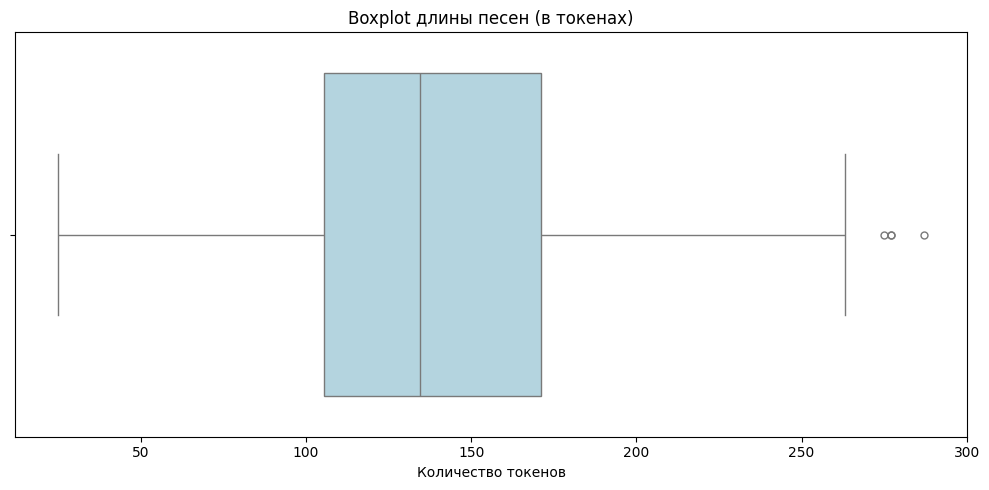

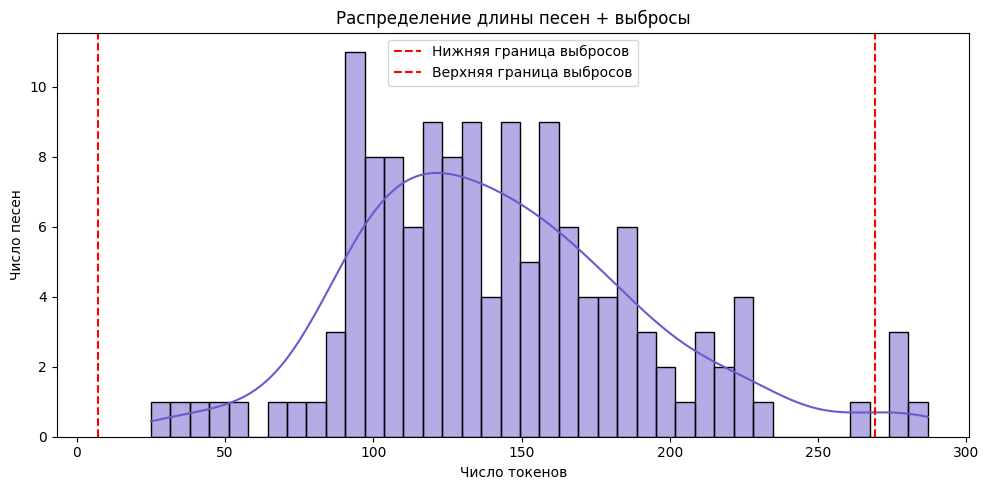

In [97]:

warnings.filterwarnings("ignore")


ROOT = Path("/content")
IN_FILE = ROOT / "data" / "albums_tokens_filtered" / "albums_tokens_filtered.json"


df = pd.read_json(IN_FILE, encoding="utf-8")


df = df[df["tokens"].notnull() & df["title"].notnull()]


df_tokens = df.explode("tokens").rename(columns={"tokens": "token"})


top_tokens = df_tokens["token"].value_counts().nlargest(30).reset_index()
top_tokens.columns = ["token", "count"]


songs_per_year = df.groupby("year")["title"].count().reset_index()
songs_per_year.columns = ["year", "count"]


df["token_count"] = df["tokens"].apply(len)


print("=== Пропущенные значения ===")
print(df.isnull().sum())


subset_cols = ["title", "album", "year"]
missing_cols = list(set(subset_cols) - set(df.columns))

if missing_cols:
    print(f"\n❗ Отсутствуют поля: {missing_cols} — они будут исключены из анализа дубликатов.")
    subset_cols = list(set(subset_cols) - set(missing_cols))


duplicates = df.duplicated(subset=subset_cols, keep=False)
print(f"\nДубликаты песен (по {', '.join(subset_cols)}): {duplicates.sum()}")


dupes = df[duplicates]
grouped = dupes.groupby(subset_cols).size().reset_index(name="count")
display(grouped.sort_values("count", ascending=False))


df_before = df.shape[0]
df = df.drop_duplicates(subset=subset_cols, keep="first")
df_after = df.shape[0]

print(f"\nУдалено дубликатов: {df_before - df_after}")
print(f"Оставлено уникальных песен: {df_after}")


df_tokens = df.explode("tokens").rename(columns={"tokens": "token"})


df["token_count"] = df["tokens"].apply(len)


Q1 = df["token_count"].quantile(0.25)
Q3 = df["token_count"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="token_count", color="lightblue", fliersize=5)
plt.title("Boxplot длины песен (в токенах)")
plt.xlabel("Количество токенов")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(df["token_count"], bins=40, kde=True, color="slateblue")
plt.axvline(lower_bound, color='red', linestyle='--', label="Нижняя граница выбросов")
plt.axvline(upper_bound, color='red', linestyle='--', label="Верхняя граница выбросов")
plt.title("Распределение длины песен + выбросы")
plt.xlabel("Число токенов")
plt.ylabel("Число песен")
plt.legend()
plt.tight_layout()
plt.show()

## Анализ и визуализация

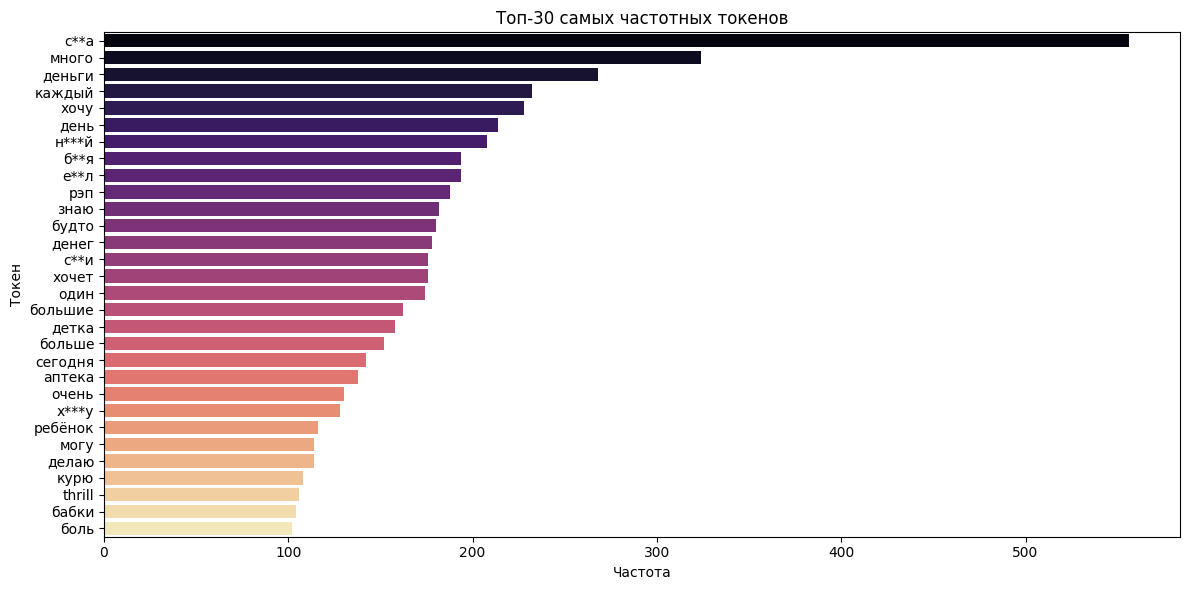

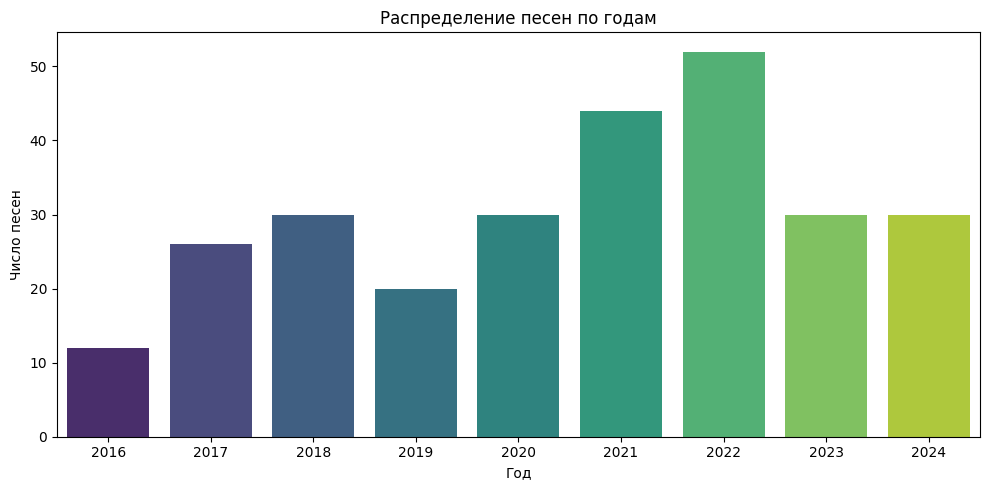

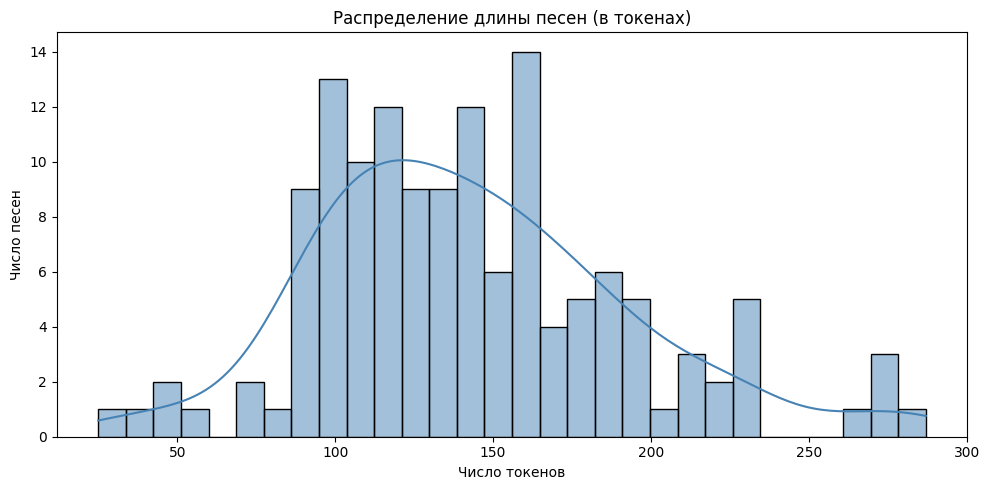

In [98]:

plt.figure(figsize=(12, 6))
sns.barplot(data=top_tokens, y="token", x="count", palette="magma")
plt.title("Топ-30 самых частотных токенов")
plt.xlabel("Частота")
plt.ylabel("Токен")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.barplot(data=songs_per_year, x="year", y="count", palette="viridis")
plt.title("Распределение песен по годам")
plt.xlabel("Год")
plt.ylabel("Число песен")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(df["token_count"], bins=30, kde=True, color="steelblue")
plt.title("Распределение длины песен (в токенах)")
plt.xlabel("Число токенов")
plt.ylabel("Число песен")
plt.tight_layout()
plt.show()

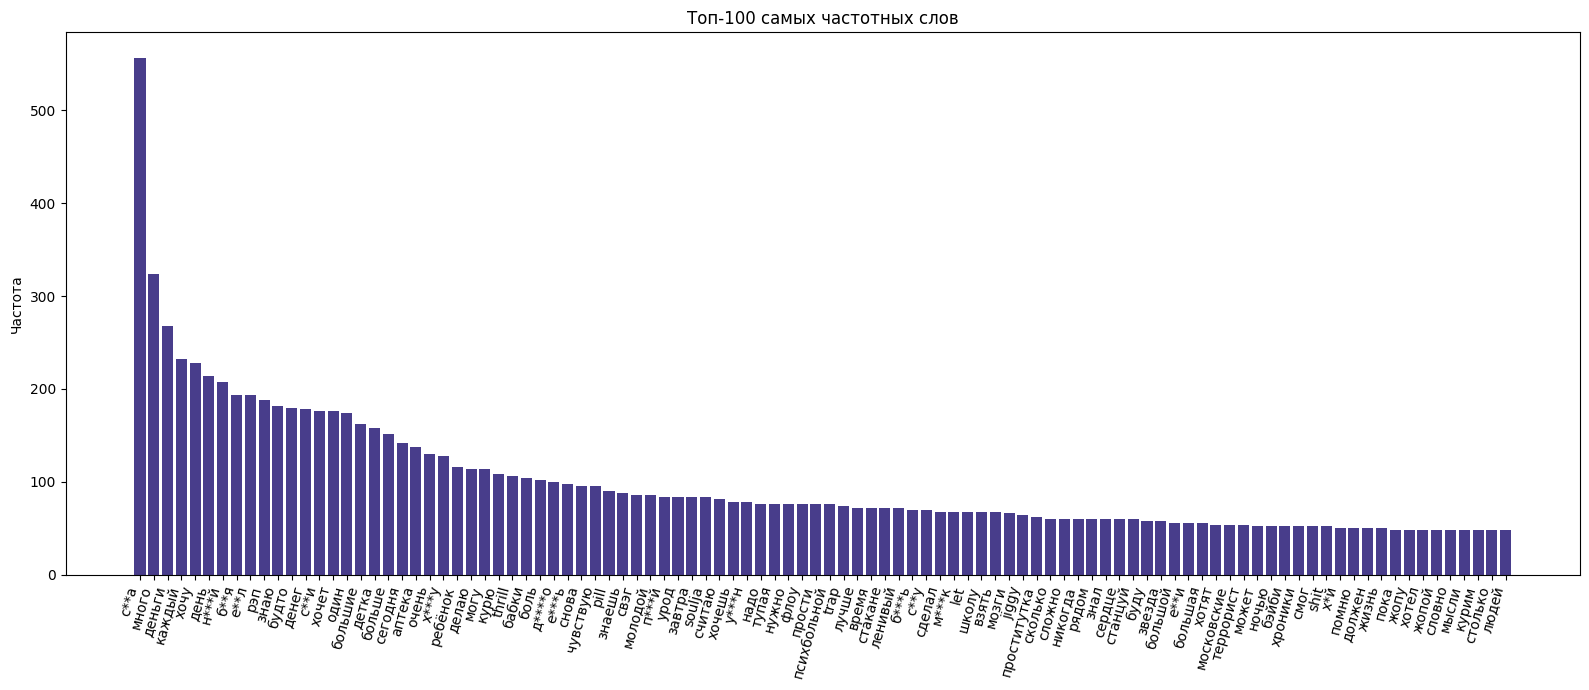

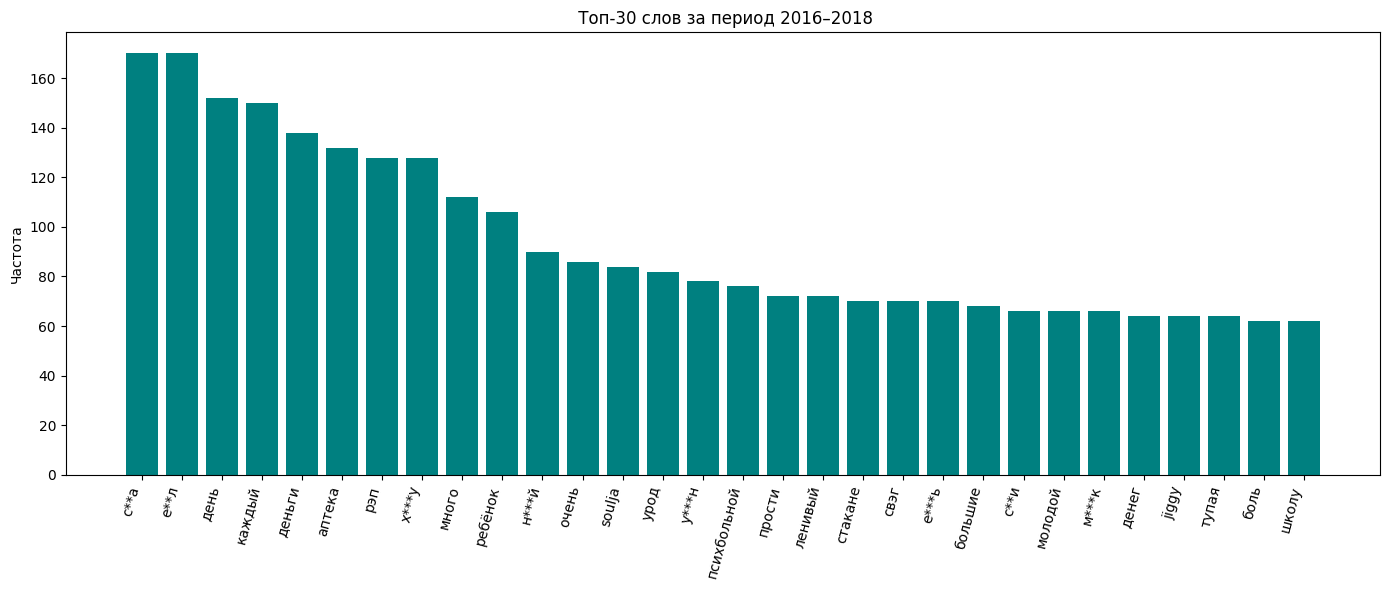

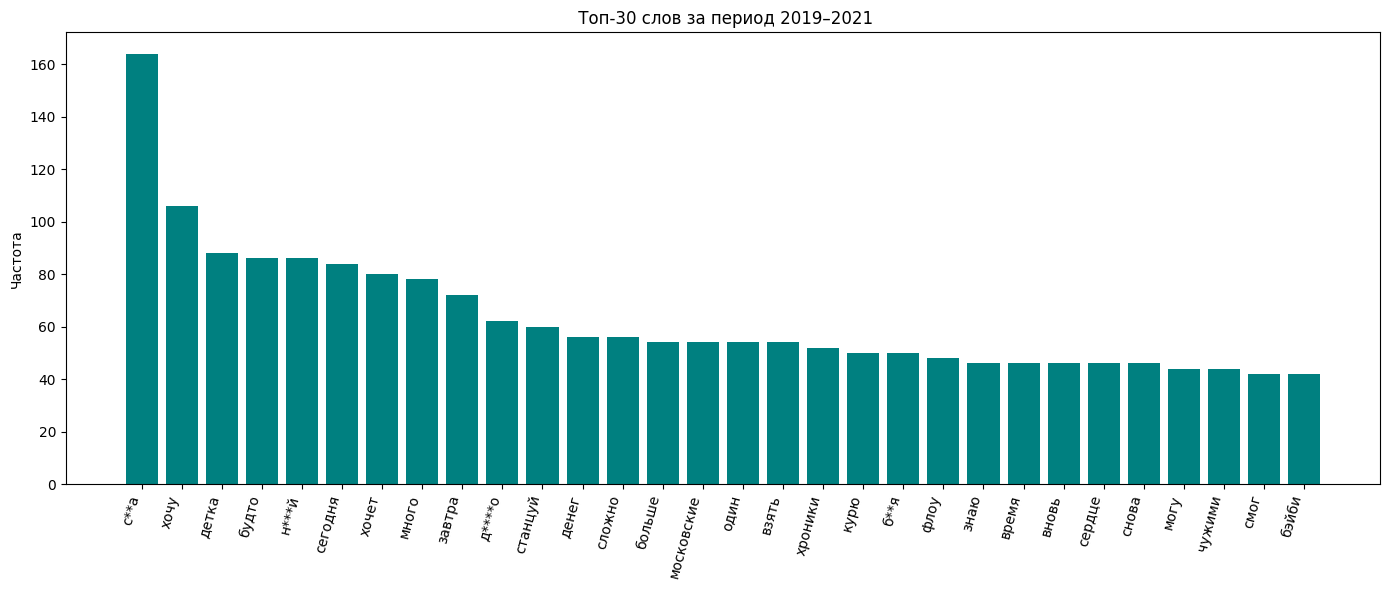

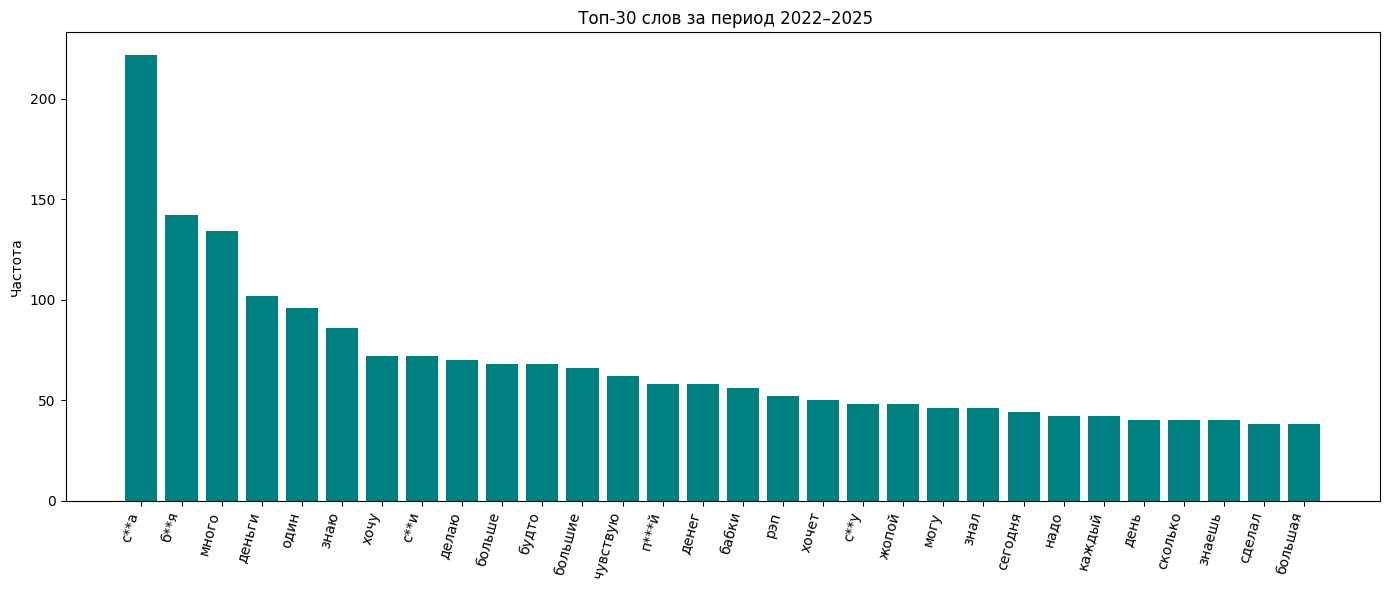

In [99]:


TOK_FILE = Path("data/albums_tokens_filtered/albums_tokens_filtered.json")

with TOK_FILE.open("r", encoding="utf-8") as f:
    records = json.load(f)

def get_period(year: str) -> str:
    y = int(year)
    if 2016 <= y <= 2018:
        return "2016–2018"
    elif 2019 <= y <= 2021:
        return "2019–2021"
    elif 2022 <= y <= 2025:
        return "2022–2025"
    return "Unknown"


all_tokens = [tok for r in records for tok in r.get("tokens", [])]
cnt_all = Counter(all_tokens)

words100, freqs100 = zip(*cnt_all.most_common(100))

plt.figure(figsize=(16, 7))
plt.bar(words100, freqs100, color="darkslateblue")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Частота")
plt.title("Топ-100 самых частотных слов")
plt.tight_layout()
plt.show()


period_tokens = {"2016–2018": [], "2019–2021": [], "2022–2025": []}
for r in records:
    period = get_period(r.get("year", "0"))
    if period in period_tokens:
        period_tokens[period].extend(r.get("tokens", []))


for period, tokens in period_tokens.items():
    counter = Counter(tokens)
    top30 = counter.most_common(30)
    words30, freqs30 = zip(*top30)

    plt.figure(figsize=(14, 6))
    plt.bar(words30, freqs30, color="teal")
    plt.xticks(rotation=75, ha="right")
    plt.ylabel("Частота")
    plt.title(f" Топ-30 слов за период {period}")
    plt.tight_layout()
    plt.show()


## Выводы

**1. Общие частотные слова**

В целом тексты Thrill Pill характеризуются сильным акцентом на «бабки/деньги», «каждый день», «хочу» и грубую лексику. Эти слова отражают основные мотивации и настроение творчества: частые упоминания денег, желания и повседневные ритуалы артиста.

**2. Эволюция лексики по периодам**

Early Years (2016–2018):
преобладают «классические» уличные темы: мат, нарко***и, деньги, swag («рэп», «аптека», «бабки»).

Middle Stage (2019–2021):
Лексика становится чуть более умеренной: «хочу», «много», «будто», «сколько». Всё ещё присутствуют грубые обороты, но чаще встречаются описания чувства и состояния. Тема нарко****в поднимается реже

Recent Stage (2022–2025):
В текстах снова становится больше мата, но к ним добавляются «деньги», «чувствую», «делаю» — артист переключается обратно на тему заработка и собственного «я». В топ 30 слов нет упоминания нарко****ских веществ. Это ярко
демонстрирует изменившееся отношение артиста к запрещённым веществам.

**3. Сдвиг тональности и тематики**

В ранний период главными темами были «нарко***и/тусовка» и «деньги/быт». В среднем этапе появляется кластер «отношения/ожидание» (слова «детка», «завтра», «много хочу»). В недавнем — «внутренние переживания» и повторные рефлексивные конструкции.



## Обсуждение

**Что планировалось и что удалось**

Целью было проанализировать, как меняется лексика Thrill Pill в разные этапы карьеры (2016–2018, 2019–2021, 2022–2025), выяснить самые частотные слова и тематики. Удалось собрать корпус из более чем 150 уникальных песен, программно получить треки, альбомы, годы и ссылки, а также вручную добавить тексты, очистить, токенизировать и построить все необходимые графики.

**Что не получилось и почему**

В ходе работы мне удалось с помощью веб-скрейпинга получить: *название альбома, список треков, год выпуска и ссылки на страницы с текстами на Genius.com* для каждого альбома Thrill Pill.
  Чтобы собрать тексты треков, я сначала попытался автоматизировать всё через Genius API и парсинг страниц с помощью requests и BeautifulSoup. Однако сами тексты оказались подгружены динамически, а структура HTML на разных страницах сильно варьировалась. Автоматический парсер работал нестабильно: части некоторых куплетов не захватывались. В результате я решил сохранить точность и полноту данных, вручную скопировав текст каждого трека в заранее подготовенный JSON.

**Как улучшить исследование**

Добавить анализ тональности и тематическую кластеризацию.

**Кому полезно**

Аналитика будет интересна хип-хоп-сообществу, маркетологам и исследователям текстов для понимания эволюции речевого стиля артиста и сравнительного анализа с другими рэперами.